# Fixing the EALSTM evaluation

In [2]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/home/jovyan/ml_drought


In [3]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch
import tqdm
from typing import List, Union, Optional, Tuple, Dict

data_dir = Path('data/')
# data_dir = Path('/Volumes/Lees_Extend/data/zip_data')
# data_dir = Path('/Volumes/Lees_Extend/data/ecmwf_sowc/data/')
# plot_dir = Path('/Users/tommylees/Downloads')

assert data_dir.exists()

In [4]:
import seaborn as sns
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data
from src.analysis.evaluation import join_true_pred_da
from src.models import load_model

# Experiment Parameters

In [5]:
np.array(sorted([d.name for d in (data_dir / "models/").glob("*timestep*")]))

array(['one_timestep_forecast'], dtype='<U21')

In [6]:
display("DYNAMIC", np.array(sorted([d.name for d in (data_dir / "features/one_timestep_forecast").glob("*")])))
# display("STATIC", np.array(sorted([d.name for d in (data_dir / "features/static").glob("*")])))

'DYNAMIC'

array(['data.nc', 'normalizing_dict.pkl'], dtype='<U20')

In [7]:
EXPERIMENT =        'one_timestep_forecast' # '2020_04_23:190425_one_timestep_forecast' 
TRUE_EXPERIMENT =   'one_timestep_forecast'
TARGET_VAR =        'discharge_spec'
STATIC_DATA_FILE =  'data.nc' # '2020_04_23:112630_data.nc_'
DYNAMIC_DATA_FILE = 'data.nc'
N_EPOCHS = 100

assert (data_dir / f"models/{EXPERIMENT}").exists()
assert (data_dir / f"features/{TRUE_EXPERIMENT}").exists()

# Look at losses

In [8]:
l1_losses = pickle.load(open(data_dir / f'models/{EXPERIMENT}/ealstm/l1_losses.pkl', 'rb'))
rmses = pickle.load(open(data_dir / f'models/{EXPERIMENT}/ealstm/rmses.pkl', 'rb'))

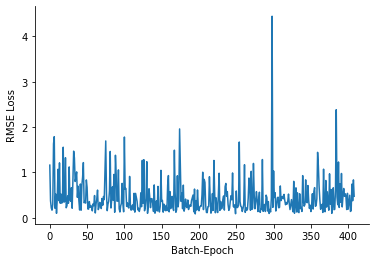

In [9]:
plt.plot(np.arange(len(rmses)), rmses)
ax = plt.gca()
ax.set_xlabel('Batch-Epoch')
ax.set_ylabel('RMSE Loss')
sns.despine()

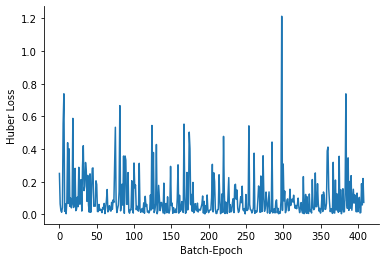

In [10]:
plt.plot(np.arange(len(l1_losses)), l1_losses)
ax = plt.gca()
ax.set_xlabel('Batch-Epoch')
ax.set_ylabel('Huber Loss')
sns.despine()

# Read in data

In [11]:
# read in model
ealstm = load_model(data_dir / f'models/{EXPERIMENT}/ealstm/model.pt')

Using the Dynamic DataLoader
	Target Var: discharge_spec
	Test Years: [2010 2011 2012 2013 2014 2015]


In [12]:
test_arrays_loader = ealstm.get_dataloader(
    mode="test", to_tensor=True, shuffle_data=False, **dict(batch_file_size=10)
)
preds_dict: Dict[str, np.ndarray] = {}
test_arrays_dict: Dict[str, Dict[str, np.ndarray]] = {}

In [14]:
len(test_arrays_loader)

209

In [12]:
test_arrays_loader = ealstm.get_dataloader(
    mode="test", to_tensor=True, shuffle_data=False, **dict(batch_file_size=10)
)
preds_dict: Dict[str, np.ndarray] = {}
test_arrays_dict: Dict[str, Dict[str, np.ndarray]] = {}

In [16]:
ealstm.model.eval()
with torch.no_grad():
    for dict in test_arrays_loader:
        for key, val in tqdm.tqdm(dict.items()):

            # TODO: this is where the code breaks down
            # ipdb> self.x.historical.shape => (659, 365, 8)
            input_tuple = ealstm._input_to_tuple(val.x)

            # TODO - this code is mostly copied from
            # models.utils - can be cleaned up
            # with a default batch size of 256
            num_sections = max(input_tuple[0].shape[0] // 256, 1)
            split_x = []
            for idx, x_section in enumerate(input_tuple):
                if x_section is not None:
                    split_x.append(torch.chunk(x_section, num_sections))
                else:
                    split_x.append([None] * num_sections)  # type: ignore

            chunked_input = list(zip(*split_x))

            all_preds = []
            for batch in chunked_input:
                all_preds.append(ealstm.model(*batch).cpu().numpy())
            preds_dict[key] = np.concatenate(all_preds)

            test_arrays_dict[key] = {
                "y": val.y.cpu().numpy(),
                "latlons": val.latlons,
                "time": val.target_time,
                "y_var": val.y_var,
                "id_to_loc_map": val.id_to_loc_map,
            }


100%|██████████| 9/9 [00:02<00:00,  3.72it/s]


In [20]:
spatial_unit_name = 'station_id'

# convert from test_arrays_dict to xarray object
for key, val in test_arrays_dict.items():
    if val["latlons"] is not None:
        latlons = cast(np.ndarray, val["latlons"])
    preds = ealstm.denormalize_y(preds_dict[key], val["y_var"])
    if len(preds.shape) > 1:
        preds = preds.squeeze(-1)
    # the prediction timestep
    time = val["time"]
    times = [time for _ in range(len(preds))]
    # get the spatial_unit from the ModelArrays
    # TODO: how are we selecting the id_to_loc_map taking into account the
    # dropped nans ?
    spatial_unit = np.array([v for v in val["id_to_loc_map"].values()])
    #  WORK with latlon or with 1D data
    try:
        preds_xr = (
            pd.DataFrame(
                data={
                    "preds": preds,
                    "lat": latlons[:, 0],
                    "lon": latlons[:, 1],
                    "time": times,
                }
            )
            .set_index(["lat", "lon", "time"])
            .to_xarray()
        )
    except NameError as E:  # non latlon data
        # print(f"data is not 2D (latlons):\n{E}")
        spatial_unit_name = (
            "spatial_unit"
            if spatial_unit_name is None
            else spatial_unit_name
        )
        preds_xr = (
            pd.DataFrame(
                data={
                    "preds": preds,
                    spatial_unit_name: spatial_unit,
                    "time": times,
                }
            )
            .set_index([spatial_unit_name, "time"])
            .to_xarray()
        )
        
    preds_xr.to_netcdf(ealstm.model_dir / f"preds_{key}.nc")